## First Attempt at building a deepsets architecture

In [2]:
import random

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
import healpy as hp



#### Experimenting with input sizes

In [4]:
# For DECAM, BASS, MzLS
with open('../bricks_data/pixel2ccd_2048_non_inclusive.pickle', 'rb') as f:
    subpixel2ccd_dict = pickle.load(f)
    f.close()

In [16]:
print(len(subpixel2ccd_dict))

28536897


In [17]:
min = 1000
max = 0
aggregate = 0
index_max = 0
lens = np.zeros(len(subpixel2ccd_dict))

for i,pix in enumerate(subpixel2ccd_dict.keys()):
    no_ccds = len(subpixel2ccd_dict[pix])
    lens[i] = no_ccds
    aggregate += no_ccds
    if no_ccds > max:
        max = no_ccds
        index_max = pix
    if no_ccds < min:
        min = no_ccds

print("Mean CCD's per subpixel:", lens.mean())
print("Max CCD's per subpixel:", max)
print("Min CCD's per subpixel:", min)



Mean CCD's per subpixel: 14.685108966122
Max CCD's per subpixel: 2978
Min CCD's per subpixel: 1


(array([26122277.,  2267658.,   107349.]),
 array([  0,  30,  50, 100]),
 <BarContainer object of 3 artists>)

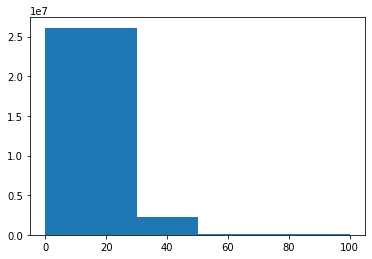

In [13]:
plt.hist(lens, bins=[0,30,50,100])


In [18]:
decamCCD = fits.open('../bricks_data/ccds-annotated-decam-dr9.fits')
mosaicCCD = fits.open('../bricks_data/ccds-annotated-mosaic-dr9.fits')
bassCCD = fits.open('../bricks_data/ccds-annotated-90prime-dr9.fits')
print(decamCCD[1].columns)


ColDefs(
    name = 'image_filename'; format = '120A'
    name = 'image_hdu'; format = 'I'
    name = 'camera'; format = '5A'
    name = 'expnum'; format = 'K'
    name = 'plver'; format = '8A'
    name = 'procdate'; format = '19A'
    name = 'plprocid'; format = '7A'
    name = 'ccdname'; format = '3A'
    name = 'object'; format = '35A'
    name = 'propid'; format = '10A'
    name = 'filter'; format = '1A'
    name = 'exptime'; format = 'E'
    name = 'mjd_obs'; format = 'D'
    name = 'airmass'; format = 'E'
    name = 'fwhm'; format = 'E'
    name = 'width'; format = 'I'
    name = 'height'; format = 'I'
    name = 'ra_bore'; format = 'D'
    name = 'dec_bore'; format = 'D'
    name = 'crpix1'; format = 'E'
    name = 'crpix2'; format = 'E'
    name = 'crval1'; format = 'D'
    name = 'crval2'; format = 'D'
    name = 'cd1_1'; format = 'E'
    name = 'cd1_2'; format = 'E'
    name = 'cd2_1'; format = 'E'
    name = 'cd2_2'; format = 'E'
    name = 'yshift'; format = 'L'
    name = 

In [19]:
dataDecam = decamCCD[1].data
dataMosaic = mosaicCCD[1].data
dataBass = bassCCD[1].data

In [20]:
#ra0 = np.concatenate((dataDecam.field('ra0'), dataMosaic.field('ra0'), dataBass.field('ra0')), axis=0)
#print(len(ra0))
ra0_decam  = dataDecam.field('ra0')
ra0_mosaic = dataMosaic.field('ra0')
ra0_bass =dataBass.field('ra0')
print(len(ra0_decam) +  len(ra0_mosaic) + len(ra0_bass))

6776431


In [21]:
ra0 = np.concatenate((dataDecam.field('ra0'), dataMosaic.field('ra0'), dataBass.field('ra0')), axis=0)
dec0 = np.concatenate((dataDecam.field('dec0'), dataMosaic.field('dec0'), dataBass.field('dec0')), axis=0)

ra1 = np.concatenate((dataDecam.field('ra1'), dataMosaic.field('ra1'), dataBass.field('ra1')), axis=0)
dec1 = np.concatenate((dataDecam.field('dec1'), dataMosaic.field('dec1'), dataBass.field('dec1')), axis=0)

ra2 = np.concatenate((dataDecam.field('ra2'), dataMosaic.field('ra2'), dataBass.field('ra2')), axis=0)
dec2 = np.concatenate((dataDecam.field('dec2'), dataMosaic.field('dec2'), dataBass.field('dec2')), axis=0)

ra3 = np.concatenate((dataDecam.field('ra3'), dataMosaic.field('ra3'), dataBass.field('ra3')), axis=0)
dec3 = np.concatenate((dataDecam.field('dec3'), dataMosaic.field('dec3'), dataBass.field('dec3')), axis=0)



### Plotting the Pixel - CCD Relationship for the most populated pixel

In [ ]:
#Validating everything went as intended visually

NSIDE_SUB = 2048
pixel_number = index_max
# print(pixel2ccd_dict.keys())
print(len(subpixel2ccd_dict.keys()))


ccd = subpixel2ccd_dict[pixel_number]
print("Number of CCDs that are cutting pixel number ", pixel_number, ":", len(ccd))
for cc in ccd:
#coord = [[x0,y0], [x1,y1], [x2,y2], [x3,y3], [x0,y0]]
    xs = [ra0[cc],ra1[cc], ra2[cc], ra3[cc],ra0[cc] ]
    ys = [dec0[cc],dec1[cc], dec2[cc], dec3[cc],dec0[cc]]
    plt.plot(xs,ys)
#if i > 3:
    #break

pixel_boundary = hp.boundaries(nside=NSIDE_SUB, pix=pixel_number, step=1)
pixel_boundary_raDec = hp.vec2ang(pixel_boundary.transpose(),lonlat=True)
pixel_boundary_raDec = list(pixel_boundary_raDec)
pixel_boundary_raDec[0] = np.append(pixel_boundary_raDec[0],pixel_boundary_raDec[0][0])
pixel_boundary_raDec[1] = np.append(pixel_boundary_raDec[1],pixel_boundary_raDec[1][0])


plt.plot(pixel_boundary_raDec[0],pixel_boundary_raDec[1], c='black', label="Pixel Boundary")

plt.show()


## Building a deepsets architecture

In [45]:
# Import NN Packages
import torch
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing, metrics
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import time
import seaborn as sns
import matplotlib.pyplot as plt
import random


print(torch.__version__)


1.9.0


## Writing Dataset Utility to pass data in the right format

#### Steps:

1. Build a NN sampling an equal number of CCDs per 256 pixel and pass through deep sets for regression

2. Adapt NN for variable sized inputs

3. Adapt NN to use 64 layers of size 2048 to then predict density at 256

In [58]:
# Preparing Data to use
df_raw = pd.read_csv('../../bricks_data/dataset_geometric.csv')


In [59]:
df_raw.head()


,pixel_id,lrg,elg,qso,stellar,EBV,airmass,fwhm,ccdskysb_g,ccdskysb_r,ccdskysb_z,exptime_g,exptime_r,exptime_z,meansky_g,meansky_r,meansky_z,galdepth_g,galdepth_r,galdepth_z
0,1673,1,8,22,4,0.150272,1.755791,4.054279,23.362753,21.275543,18.728977,250.0,250.000000,178.104004,0.350981,7.418882,3.168162,23.455763,21.988368,22.284269
1,1675,21,45,84,13,0.231753,1.752745,4.333361,23.412788,21.349841,18.934986,215.0,240.000000,160.604004,0.324769,5.615912,2.599613,23.448900,22.083221,22.318394
2,1676,1,10,14,4,0.233339,1.752675,4.432289,23.463202,21.424571,19.099052,180.0,230.000000,171.106506,0.288073,3.914232,2.233619,23.412380,22.185323,22.341307
3,1677,16,44,82,8,0.198980,1.743200,4.533583,23.463299,21.424380,19.140076,180.0,230.000000,176.439677,0.291843,3.932022,2.134053,23.508274,22.167623,22.373904
4,1678,22,45,94,14,0.178034,1.725647,4.229492,23.385620,21.436897,19.110413,215.0,237.916667,213.606003,0.305991,4.657650,2.125587,23.555042,22.131536,22.489397


In [62]:
num_pixels = 5
gal_type = 'lrg'


ids = random.sample(range(len(df_raw)),num_pixels)
print(ids)
df = df_raw.iloc[ids]
print(df.head())
labels = df[gal_type].to_numpy()
pix_ids = df.pixel_id.to_numpy()
print(labels)
print(pix_ids)




[71753, 130600, 51906, 43998, 252501]
        pixel_id  lrg  elg  qso  stellar       EBV   airmass      fwhm  \
71753     201172   41  112  165       45  0.058632  1.964117  5.410365   
130600    321369    2    7    8        3  0.019776  1.488935  4.682151   
51906     154862    7   84   75       29  0.034859  1.074779  3.602058   
43998     130203   23   93  102       20  0.029121  1.044090  3.318905   
252501    706734    7   15   32       10  0.032291  1.113788  4.421265   

        ccdskysb_g  ccdskysb_r  ccdskysb_z   exptime_g   exptime_r  \
71753    23.627783   22.751667   19.797377  136.800000   56.500000   
130600   23.290599   22.617348   19.956287  141.333333   85.000000   
51906    23.545366   22.665709   19.003794   94.349998  162.994604   
43998    23.610138   22.725484   19.414363  108.185333   68.276332   
252501   23.593163   22.628382   20.018324   90.000000   90.000000   

         exptime_z     meansky_g     meansky_r     meansky_z  galdepth_g  \
71753   120.017497  

In [ ]:
# noinspection PyAttributeOutsideInit
class SetSequence(Dataset):
    """Processes and Returns a Dataset of Variable Sized Input Sets of Dimensions
    N = Number Pixels of that are returned
    M = Max Size of each Individual Set of CCDs


    """

    def __init__(self, gal_type = 'lrg', num_pixels = 3, min_ccds = 10, max_ccds = 30, var_set_len = False):

        self.gal_type = gal_type

        # Dimensions
        self.num_pixels = num_pixels
        self.max_ccds = max_ccds
        self.min_ccds = min_ccds
        self.var_set_len = var_set_len

        # Features:
        df_raw = pd.read_csv('../../bricks_data/dataset_geometric.csv')
        # Randomly Sampling Pixel Indices from Dataframe
        pixel_indices = random.sample(range(len(df_raw)), num_pixels)
        print(pixel_indices)
        self.df = df_raw.iloc[ids]
        self.labels = df[gal_type].to_numpy()
        self.pix_ids = df.pixel_id.to_numpy()
        print(labels)
        print(pix_ids)



        # Target
        self.label = np.random.rand(self.num_pixels*self.max_ccds)


        # Mask Variable Len Sets
        self.set_max_set_len()


    def set_max_set_len(self):
        self.index_matrix =  -1*np.ones((self.num_pixels, self.max_ccds), dtype=int)
        self.lengths = np.zeros(self.num_pixels, dtype=int)

        # Getting random labels for now, in the future this will be the output densities

        m = 0
        for i in range(self.num_pixels):
            if self.var_set_len:
                # Replace this by function indicating how many ccds are in a given pixel
                self.lengths[i] = np.random.randint(self.min_ccds, self.max_ccds+1)
            else:
                self.lengths[i] = self.max_ccds
            for j in range(self.lengths[i]):
                ''' This code with label == 0 is not yet needed, but this masking will become necessary when I have
                    I have 64 subpixels per pixel and some of those are not covered by CCDs'''
                while self.label[m] == 0:
                    m += 1
                self.index_matrix[i, j] = m
                m += 1

        print(self.lengths)
        print(self.index_matrix)

    def __len__(self):
        return self.num_pixels

    def __getitem__(self, index):
        seq_len = self.lengths[index]

        # Replace by X and Y
        X = torch.zeros(self.max_ccds, 1, self.img_size, self.img_size)
        Y = torch.zeros(self.max_ccds).long()

        for i in range(seq_len):
            j = self.index_matrix[index, i]
            X[i] = torch.from_numpy(self.img[j])
            Y[i] = torch.from_numpy(self.label[j]).long().unsqueeze(1)

        return X, Y, seq_len

In [43]:
traindata = SetSequence()


[30 30 30]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
  54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
  84 85 86 87 88 89]]


In [42]:
class DensitySurvey(Dataset):
    def __init__(self, df, galaxy_type, scaler_in=None, scaler_out=None):
        self.data = df
        # Extracting Targets and Input
        self.target = self.data[galaxy_type].to_numpy(copy=True)
        self.input = self.data.drop(columns=['lrg','elg','qso']).to_numpy(copy=True)

        # Scaling, when scaler is passed (test-set) use the existing scaler
        self.scaler_in = scaler_in
        self.scaler_out = scaler_out
        if self.scaler_in is None:
            self.scaler_in = preprocessing.MinMaxScaler()
            self.scaler_out = preprocessing.MinMaxScaler()
            self.input = self.scaler_in.fit_transform(self.input)
            self.target = self.scaler_out.fit_transform(self.target.reshape(-1, 1))
        else:
            self.input = self.scaler_in.transform(self.input)
            self.target = self.scaler_out.transform(self.target.reshape(-1, 1))


    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return torch.from_numpy(self.input[idx]).float(), torch.tensor(self.target[idx]).float()


In [ ]:
dens = DensitySurvey